In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c rdkit rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-04-22 11:53:02--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-04-22 11:53:02--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / 
The environment is inconsistent, please check the

In [1]:
import molml
from molml.features import BagOfBonds
import csv
import numpy as np
import sklearn
import math
import random
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from scipy.io import loadmat
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import tqdm.auto as tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import rdkit, rdkit.Chem.AllChem, rdkit.Chem.Crippen
import rdkit.Chem as Chem
from rdkit.Chem import Draw

import torch
import sklearn.linear_model, sklearn.model_selection

In [ ]:
!pip install molml

# Recap

## Extended Connectivity Fingerprints

1. Compute a unique index for each atom. This is a long integer hash made using the following features (Daylight atomic invariants)

* Number of non-hydrogen immediate neighbors
* Valency minus the number of connected hydrogens (i.e., total bond order ignoring H)
* Atomic number
* Atomic mass
* Atomic charge
* Number of attached hydrogens (both implicit and explicit)

2. Aggregate information from neighboring atoms and bonds connecting to them and use it to compute new feature vector.

    `[bond-order-1, atom-1-hash, bond-order-1, atom-2-hash, ...]`

    We hash this list to generate the 1-st iteration features for the atoms. These features in the 1-st iteration grab information from radius 1, diameter 2. We repeat this proecss, the 2-nd iteration vector will have information from radius 2, diameter 4.

    We do this for 2-3 iterations, leading to the different ECFP types, **ECFP-4, ECFP-6**, etc., depending on the diameter of data aggregation. 
    
    We also keep track of which bonds and atoms are getting aggregated in each iteration, and we de-duplicate the same neighborhood being added as a feature from two different starting points.

3. Given a target vector size, say 2048, take all the computed hashes over all iterations and find their values in this mod-field. i.e. `feature-id = hash-index % 2048`.

    Marks these feature ids in a 2048 length bit-vector, which now represents a hashed list of unique atom features, and substructure features upto small radii.

The following features are important to note about ECFP:
* The Hydrogen atoms are not a part of the fingerprinting process.
* ECFP depends on the hash function implementation of each programming language and therefore may differ in value from implementation to implementation.
* ECFP-4 is sufficient for most clustering or similarity indexing tasks.
* ECFP-6 or ECFP-8 might be needed for activity prediction tasks.


Refer to https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html for a detailed explainiation.

In [2]:
molecule = "C1CCCC1"

fingerprint = np.asarray(
    rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(
        rdkit.Chem.MolFromSmiles(molecule),
        radius=3,
        nBits=64
    )
)

print("Morgan Fingerprint of Benzene", fingerprint)

Morgan Fingerprint of Benzene [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [3]:
len(fingerprint)

64

Morgan fingerprint is a type of ECFP.

## Molecule Similarity

$$\text{Travsky}_{a,b}(V_i, V_j) = \frac{V_i \cdot V_j}{a ||V_i||_1 + b ||V_j||_1 + (1 - a- b) V_i \cdot V_j}$$

Travsky similarity is the general framework in which all other fingerprint similarity measures fit.

$$\text{Tanimoto}(V_i, V_j) = \text{Travsky}_{1,1}(V_i, V_j)$$

Tanimoto similarity is the ratio of the number of molecular features present in both molecules (intersection) over the number of molecular features present in either molecule (union).

$$\text{Tanimoto}(V_i, V_j) = \frac{V_i \cdot V_j}{||V_i||_1 + ||V_j||_1 - V_i \cdot V_j}$$

$$\text{Dice}(V_i, V_j) = \text{Travsky}_{0.5,0.5}(V_i, V_j)$$

Tanimoto similarity is the ratio of the number of molecular features present in both molecules (intersection) over the average number of molecular features present in both the molecules (mean of L1 norm).

$$\text{Dice}(V_i, V_j) = \frac{V_i \cdot V_j}{\frac{1}{2} ||V_i||_1 + \frac{1}{2} ||V_j||_1}$$

In [9]:
def generate_molecule_data(batch_size=128):
    smiles, data = [], []
    with open("Data/gdb11_size08 (1).smi", "r") as f:
        for dataline in tqdm.tqdm(list(f.readlines())):
            smile = dataline.split()[0]
            molecule = rdkit.Chem.MolFromSmiles(smile)
            fingerprint = rdkit.Chem.RDKFingerprint(molecule)
            data.append(fingerprint)
            smiles.append(smile)
    return data, smiles

In [10]:
fingerprints, smiles = generate_molecule_data()

  0%|          | 0/66706 [00:00<?, ?it/s]

In [11]:
molecule_idx = np.random.randint(len(fingerprints))
similarities = [
    rdkit.DataStructs.FingerprintSimilarity(
        fingerprints[molecule_idx],
        fingerprint
    )
    for fingerprint in fingerprints
]
indexes = np.argsort(similarities)[::-1]

In [12]:
smiles[indexes[0]], smiles[molecule_idx]

('CC(CF)=CC1CO1', 'CC(CF)=CC1CO1')

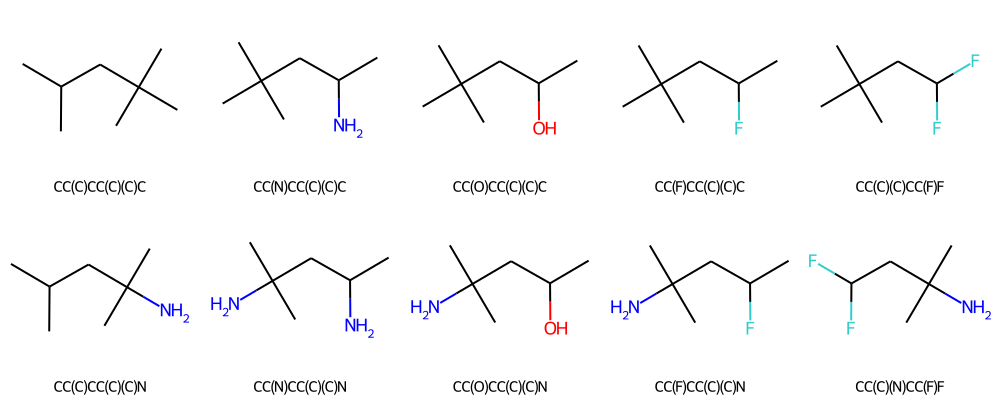

In [13]:
img = rdkit.Chem.Draw.MolsToGridImage(
    [rdkit.Chem.MolFromSmiles(smile) for smile in smiles[:10]],
    molsPerRow=5,
    legends=smiles[:10]
)
img

## Exercise: Predict Molar Refractivity (MR) values

In [14]:
import rdkit.Chem.Crippen

mr = np.array([
    rdkit.Chem.Crippen.MolMR(rdkit.Chem.MolFromSmiles(smile))
    for smile in tqdm.tqdm(smiles)
], dtype=np.float32)

  0%|          | 0/66706 [00:00<?, ?it/s]

In [15]:
mr

array([38.91  , 37.7214, 35.7528, ..., 28.4837, 26.433 , 29.417 ],
      dtype=float32)

Now you are given the list of all smiles and the list of all MR values for those smiles. Use RDKit fingerprints and Morgan fingerprints along with any other fingerprint methods of your choice, and evaluate which perform best as input to a linear regressor.

First we classify based on RDKit Fingerprints.

In [16]:
fingerprint_array = np.array([
    list(map(float, fingerprint.ToBitString()))
    for fingerprint in tqdm.tqdm(fingerprints)
], dtype=np.float32)

  0%|          | 0/66706 [00:00<?, ?it/s]

In [22]:
fingerprint_array.shape, mr.shape

((66706, 2048), (66706,))

In [23]:
model = sklearn.linear_model.LinearRegression()

fingerprint_array_train, fingerprint_array_test, mr_train, mr_test = \
    sklearn.model_selection.train_test_split(
        fingerprint_array, mr, test_size=0.2)

model.fit(fingerprint_array_train, mr_train)

print("RMS error in Train Data:",
      np.mean(np.square(mr_train - model.predict(fingerprint_array_train))))
print("Variance in the Train Data:", np.var(mr_train))

print("RMS error in Test Data:",
      np.mean(np.square(mr_test - model.predict(fingerprint_array_test))))
print("Variance in the Test Data:", np.var(mr_test))

RMS error in Train Data: 1.1543611
Variance in the Train Data: 12.815848
RMS error in Test Data: 1.2810694
Variance in the Test Data: 12.67802


Here we are actually able to make the predictions based on substructure hashes, this is because there might be substructures common across drug like molecules.

Now we use Morgan Fingerprints for the same classification.

In [24]:
morgan_fingerprint_array = np.stack([
    np.asarray(
        rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(
            rdkit.Chem.MolFromSmiles(smile),
            radius=1,
            nBits=128
        )
    )
    for smile in tqdm.tqdm(smiles)
])

  0%|          | 0/66706 [00:00<?, ?it/s]

In [25]:
model = sklearn.linear_model.LinearRegression()

fingerprint_array_train, fingerprint_array_test, mr_train, mr_test = \
    sklearn.model_selection.train_test_split(
        morgan_fingerprint_array, mr, test_size=0.2)

model.fit(fingerprint_array_train, mr_train)

print("RMS error in Train Data:",
      np.sqrt(np.mean(np.square(mr_train - model.predict(fingerprint_array_train)))))
print("Variance in the Train Data:", np.var(mr_train))

print("RMS error in Test Data:",
      np.sqrt(np.mean(np.square(mr_test - model.predict(fingerprint_array_test)))))
print("Variance in the Test Data:", np.var(mr_test))

RMS error in Train Data: 1.991939542819409
Variance in the Train Data: 12.75888
RMS error in Test Data: 1.9953793048501973
Variance in the Test Data: 12.904697


# Coulomb Matrix

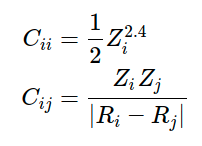


$Z_i$ is the nuclear charge of atom i and $R_i$ is its position. The Coulomb matrix has built-in invariance to translation and rotation of the molecule. 

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from scipy.io import loadmat
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [27]:
!unzip qm7.mat.zip

unzip:  cannot find or open qm7.mat.zip, qm7.mat.zip.zip or qm7.mat.zip.ZIP.


In [28]:
raw_data = loadmat("Data/qm7.mat")
raw_data['X'][0]

array([[36.858105  ,  2.9076326 ,  2.907612  ,  2.9075644 ,  2.9053485 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 2.9076326 ,  0.5       ,  0.29672   ,  0.29671896,  0.2966784 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 2.907612  ,  0.29672   ,  0.5       ,  0.29671845,  0.29667813,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.    

In [29]:
plt.style.use("ggplot")

In [30]:
def coulomb_matrix_experiment(kernel="rbf"):
  trainVsMae = []
  for train_size in range(1000, 6000, 500): #iterating through different train sizes
    if train_size > 5732: train_size = 5732
    mae = np.array([])
      
    for validation_no in tqdm(range(5), desc="Running cross validation for size {} \n".format(train_size)): #different crossvalidation
          
        #Randomly making test and train data indices
        
        test_data_indices = raw_data['P'][validation_no].flatten()
        train_data_indices = np.array(list(set(raw_data['P'].flatten()) - set(test_data_indices)))[:train_size]
        
        train_data_X = raw_data['X'][train_data_indices]
        print(train_data_X[0])
        train_data_Y = raw_data['T'][0][train_data_indices]
        
        test_data_X = raw_data['X'][test_data_indices].reshape(1433,23*23)
        test_data_Y = raw_data['T'][0,test_data_indices]
        
        train_X_reshaped = train_data_X.reshape(len(train_data_X),23*23)
        if kernel=="rbf":
          reg_mod = KernelRidge(alpha = 1e-3, kernel = "rbf", gamma=0.0001389)
        else:
          reg_mod = KernelRidge(alpha = 1e-8, kernel = "laplacian", gamma=1/4000)
        train_X_reshaped = train_X_reshaped.astype(np.float32)
        train_data_Y = train_data_Y.astype(np.float32)
        reg_mod.fit(train_X_reshaped, train_data_Y)
        predictions = reg_mod.predict(test_data_X)
        mae = np.append(mae, mean_absolute_error(test_data_Y, predictions))
        # print(" Train Size : {:n} , valid: {:n}  MAE: {:f}".format(train_size, validation_no, mae[-1]))
    trainVsMae = np.append(trainVsMae, np.average(mae))
    print("Net mae for train_size : {:n} = {:f}".format(train_size, trainVsMae[-1]))
  fig = sns.pointplot(np.arange(1000, 6000, 500), trainVsMae, markers="x")
  plt.xlabel("Training Size")
  plt.ylabel("MAE")
  plt.title("Error vs Training size for kernel: {}".format(kernel))
  plt.show()
  return trainVsMae

Running cross validation for size 1000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 1500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 2000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 2500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 3000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.5928e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.11809e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.44741e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.71372e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.74719e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Running cross validation for size 3500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.65842e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.05529e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.29709e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.9913e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.43295e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Running cross validation for size 4000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.73707e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.3454e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.34212e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.37851e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.80732e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Running cross validation for size 4500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.94253e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.09474e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.73714e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.699e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16201e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Running cross validation for size 5000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.61562e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.27519e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.2754e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.26264e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.48011e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Running cross validation for size 5500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.2269e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.11185e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.09146e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.07225e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

/home/dibyendu/Soft/anaconda3/envs/MLDD/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.39307e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Net mae for train_size : 5500 = 9.113075


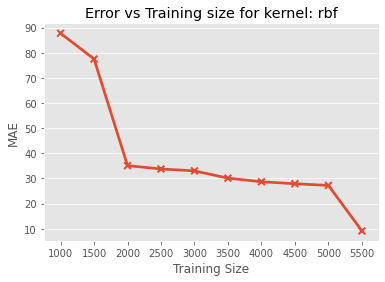

In [31]:
errors = coulomb_matrix_experiment(kernel="rbf")

Running cross validation for size 1000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 1500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 2000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 2500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 3000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 3500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 4000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 4500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 5000 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

Running cross validation for size 5500 
:   0%|          | 0/5 [00:00<?, ?it/s]

[[36.858105   12.599944    2.9019997   1.4731182   1.4731014   2.9019725
   2.9018855   1.4731016   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [12.599944   36.858105    1.4731166   2.901989    2.9019814   1.4731002
   1.4731047   2.901884    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9019997   1.4731166   0.5         0.21177544  0.2115197   0.29826015
   0.29825798  0.17260545  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.4731182   2.901989    0.21177544  0.5         0.29826027  0.21151981
   0.17260566  0.29825732  0.          0.          0.          0.
   0.          0.          0.          0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

[[36.858105    2.9076326   2.907612    2.9075644   2.9053485   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9076326   0.5         0.29672     0.29671896  0.2966784   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.907612    0.29672     0.5         0.29671845  0.29667813  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 2.9075644   0.29671896  0.29671845  0.5         0.29667678  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.  

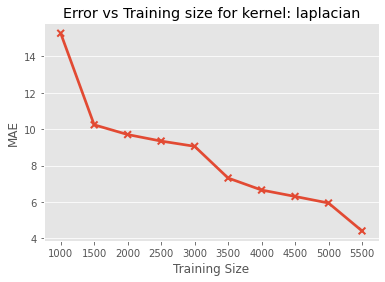

In [32]:
errors_lap = coulomb_matrix_experiment(kernel="laplacian")

# Bag Of Bonds

 [Reference](https://https://pubs.acs.org/doi/pdf/10.1021/acs.jpclett.5b00831)

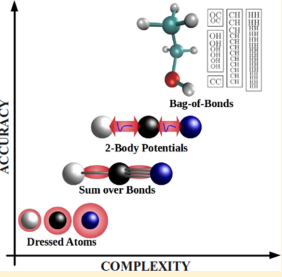

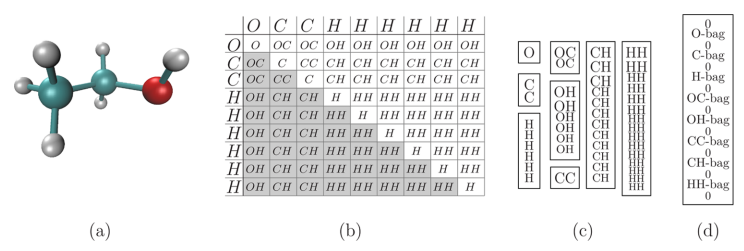 


The Bag of Bonds (BOB) is a way to represent molecule, it tries to capture not only the interatomic properties of neighbouring atoms but all the combinations of atoms possible.

BOB for a moleulce can be easily computed, first get all sets of single atoms and double atoms pair possible for a given molecule and find their interatomic potential ( Zi*Zj/|Ri − Rj| ). Then create bag of similar bonds (put all similar bonds together like put all H together put all OH tohether, etc). Then sort the bags. Finally concatenate all the bags with one another with appropriate zero padding.

#### Generating the Bag Of Bonds

In [33]:
# Reading the file and get the BagOfBonds for each molecule which will then be used to predict atomisation energy

molecules=[]
for i in range(7165):
    molecules.append([[],[]])
energy=[]
f=open("Data/dsgdb7ae.xyz","r")
k=0
while True:
    atom_num=f.readline()
    energy.append(float(f.readline()))
    
    for i in range(int(atom_num)):
        tmp=(f.readline().split("         "))
        coord=tmp[1].split("       ")
        molecules[k][0].append(tmp[0])
        molecules[k][1].append([float(coord[0]),float(coord[1]),float(coord[2])])
    k+=1
    if(k==7165):
        break
    f.readline()

In [ ]:
# molecules is a list of all the molecules in the dataset
# Each molecule consists of 2 lists, first list consists of atoms present in the molecule, 
# Second list consists of coordinates corresponding to the atoms
molecules[0],energy[0] 

([['C', 'H', 'H', 'H', 'H'],
  [[0.99826, -0.00246, -0.00436],
   [2.09021, -0.00243, 0.00414],
   [0.63379, 1.02686, 0.00414],
   [0.62704, -0.52773, 0.87811],
   [0.64136, -0.50747, -0.9054]]],
 -417.96)

In [34]:
# generating the BagOfBonds using molml 
feat = BagOfBonds(add_atoms=True)

feat.fit(molecules)

bagsofbonds=feat.transform(molecules)
print(bagsofbonds[0].shape,bagsofbonds[0])

(386,) [36.8581052   0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          5.49462923  5.49459062
  5.49450051  5.49031317  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.      

####function of bag of bonds just for reference


In [ ]:
def bagofbonds(molecules):
    bond_nums={}
    bond_types=[]
    size_of_bag=0
    bags=[]
    nuclear_charges={'C':6,'N':7,'O':8,'S':16,'H':1}
    for mol in molecules:
        mol_bond_nums={}
        mol_bond_types=[]

        for i in range(len(mol[0])):
            for j in range(len(mol[0])):
               
                if i != j:
                    
                    if str(mol[0][i]+mol[0][j]) not in mol_bond_types:
                        if str(mol[0][j]+mol[0][i]) not in mol_bond_types:
                            mol_bond_types.append(str(mol[0][i]+mol[0][j]))
                            mol_bond_nums[str(mol[0][i]+mol[0][j])] = 1
                        else:
                            mol_bond_nums[str(mol[0][j]+mol[0][i])] += 1
                            
                    else:
                        mol_bond_nums[str(mol[0][i]+mol[0][j])] +=1
                else:
                    
                    if str(mol[0][i]) not in mol_bond_types:
                        mol_bond_types.append(str(mol[0][i]))
                        mol_bond_nums[str(mol[0][i])] = 1
                    else:
                        mol_bond_nums[str(mol[0][i])] +=1

        for bond in mol_bond_types:
            if bond not in bond_types:
                if bond[::-1] in bond_types:
                    if bond_nums[bond[::-1]] < mol_bond_nums[bond]:
                        bond_nums[bond[::-1]] = mol_bond_nums[bond]
                else:
                    bond_types.append(bond)
                    bond_nums[bond]=mol_bond_nums[bond]
            else:
                if bond_nums[bond] < mol_bond_nums[bond]:
                    bond_nums[bond] = mol_bond_nums[bond]
    for i in bond_nums:
        if len(i) == 2:
            bond_nums[i]/=2
        size_of_bag+=bond_nums[i]
        
    for mol in molecules:
        bag=[]
        coulomb_matrix={}
        for i in range(len(mol[0])):
            for j in range(i+1):
                if i == j:
                    if str(mol[0][i]) not in coulomb_matrix.keys():
                        coulomb_matrix[str(mol[0][i])]=[0.5*(nuclear_charges[str(mol[0][i])])**2.4]
                    else:
                        coulomb_matrix[str(mol[0][i])].append(0.5*(nuclear_charges[str(mol[0][i])])**2.4)
                else:
                    if str(mol[0][i]+mol[0][j]) in coulomb_matrix.keys():
                        coulomb_matrix[str(mol[0][i]+mol[0][j])].append(((nuclear_charges[str(mol[0][i])]*nuclear_charges[str(mol[0][j])])/abs(np.linalg.norm(np.array(mol[1][i])-np.array(mol[1][j]),ord=2))))
#                         print(abs(np.linalg.norm(np.array(mol[1][i])-np.array(mol[1][j]),ord=2)))
                    elif str(mol[0][j]+mol[0][i]) in coulomb_matrix.keys():
                        coulomb_matrix[str(mol[0][j]+mol[0][i])].append(((nuclear_charges[str(mol[0][i])]*nuclear_charges[str(mol[0][j])])/abs(np.linalg.norm(np.array(mol[1][i])-np.array(mol[1][j]),ord=2))))
#                         print(abs(np.linalg.norm(np.array(mol[1][i])-np.array(mol[1][j]),ord=2)))
                    else:
                        coulomb_matrix[str(mol[0][i]+mol[0][j])]=[((nuclear_charges[str(mol[0][i])]*nuclear_charges[str(mol[0][j])])/abs(np.linalg.norm(np.array(mol[1][i])-np.array(mol[1][j]),ord=2)))]
#                         print(abs(np.linalg.norm(np.array(mol[1][i])-np.array(mol[1][j]),ord=2)))
                                
        for bond in bond_nums:
            
            if bond in coulomb_matrix.keys():
            
                coulomb_matrix[bond].sort(reverse=True)
                
                for value in coulomb_matrix[bond]:
                    bag.append(value)
                
                for i in range(int(bond_nums[bond])-len(coulomb_matrix[bond])):
                    bag.append(0)
            
            elif bond[::-1] in coulomb_matrix.keys():
                
                coulomb_matrix[bond[::-1]].sort(reverse=True)
                
                for value in coulomb_matrix[bond[::-1]]:
                    bag.append(value)
                
                if bond[::-1] in bond_nums.keys():
                    for i in range(int(bond_nums[bond[::-1]])-len(coulomb_matrix[bond[::-1]])):
                        bag.append(0)
                elif bond in bond_nums.keys():
                    for i in range(int(bond_nums[bond])-len(coulomb_matrix[bond[::-1]])):
                        bag.append(0)
                else:
                    print("ERROR")

            else:
                
                for i in range(int(bond_nums[bond])):
                    bag.append(0)
        
#         print(coulomb_matrix,bond_nums)
#         if len(bag) != 386:
#         print("****")
#         print((bag))
        bags.append(bag)
    return bags

#### Using Kernel Regression to predict the atomisattion Energy

In [35]:
# Train Test Split, cant use the train_test_split directly 
number=list(range(7165))
random.shuffle(number)
trainx=[]
trainy=[]
for i in number[0:int(0.8*len(number))]:
    trainx.append(bagsofbonds[i])
    trainy.append(energy[i])
testx=[]
testy=[]
for i in number[int(0.8*len(number)):]:
    testx.append(bagsofbonds[i])
    testy.append(energy[i])

In [36]:
clf = KernelRidge(alpha=0,kernel='laplacian',gamma=1/(len(bagsofbonds[0])*3.5))
clf.fit(trainx, trainy)
pred=clf.predict(testx)

In [37]:
print("RMSE for the Train Set",mean_squared_error(trainy, clf.predict(trainx),squared=False))
print("RMSE for the Test Set",mean_squared_error(testy, pred,squared=False))

RMSE for the Train Set 5.5003606086909274e-11
RMSE for the Test Set 4.660211820552435


## Making a Vocabulary Using a Smiles Database and using a simple RNN to predict solvation energy 


In [38]:
import torch
from torch import nn
import numpy as np
import torch.optim as optim
from tqdm.auto import tqdm
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [39]:
df = pd.read_csv('./esol.csv')
df = df[['measured log solubility in mols per litre','smiles']]
print(len(df))
train_df, validate_df, test_df = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

1128


In [47]:
help(re.sub)

Help on function sub in module re:

sub(pattern, repl, string, count=0, flags=0)
    Return the string obtained by replacing the leftmost
    non-overlapping occurrences of the pattern in string by the
    replacement repl.  repl can be either a string or a callable;
    if a string, backslash escapes in it are processed.  If it is
    a callable, it's passed the Match object and must return
    a replacement string to be used.



In [48]:
elements = {'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S','H','Si'}
vocab = set()
for indx,val in enumerate(list(df['smiles'].values)):
    temp_smile = re.sub(' ','',val)   ##remove spaces from the smile string
    for element in elements:
        search_obj = re.search(element,temp_smile)
        
        if search_obj:
            temp_smile = re.sub(element,'',temp_smile)
            #print(temp_smile)
            vocab.add(element)
        search_obj = re.search(element.lower(),temp_smile)
        if search_obj:
            temp_smile = re.sub(element.lower(),'',temp_smile)
            vocab.add(element.lower())
    
    for i in temp_smile:
        vocab.add(i)
## convert vocab from set to list for indexing
vocab = list(vocab)
vocab

['I',
 '6',
 '1',
 ')',
 '#',
 '(',
 'l',
 '2',
 '\\',
 's',
 'S',
 ']',
 'H',
 'C',
 '4',
 'n',
 '[',
 'O',
 'c',
 'F',
 '=',
 'P',
 'o',
 'N',
 '7',
 '3',
 '/',
 'Br',
 '8',
 '5']

In [70]:
def smiles2vec(smile):
    indx = 0
    vec = []
    smile = smile.strip()
    while indx < len(smile):
        if (indx is not len(smile) - 1) and (smile[indx] + smile[indx+1]) in vocab:
            #print(smile[indx]+smile[indx+1])

            vec.append(vocab.index(smile[indx] + smile[indx+1]))
            indx += 2
            
        elif (smile[indx]) in vocab:
            vec.append(vocab.index(smile[indx]))
            indx += 1
            
    return vec

In [61]:
train_df.values[0][1]

'CCCCCCCCCC(=O)OCC'

In [62]:
vocab.index("C")

13

In [63]:
smiles2vec(train_df.values[0][1])

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 5, 20, 17, 3, 17, 13, 13]

In [44]:
for i in smiles2vec(train_df.values[0][1]):
  print(i,"    ",vocab[i])

13      C
13      C
13      C
13      C
13      C
13      C
13      C
13      C
13      C
13      C
5      (
20      =
17      O
3      )
17      O
13      C
13      C


In [64]:
INPUT_SIZE = 1      # rnn input size
HIDDEN_SIZE = 120      # rnn hidden size
LR = 1e-2         # learning rate
BATCH_SIZE = 32

In [71]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,     # rnn hidden unit
            num_layers=1,                # number of rnn layer
            batch_first = True,
        )
        self.out = nn.Linear(HIDDEN_SIZE, 60)
        self.final = nn.Linear(60, 1)

    def forward(self, x, time_step):
        h_state = torch.zeros(1,1,HIDDEN_SIZE).float()
        r_out, h_state = self.rnn(x.float(), h_state)
        r_out = torch.mean(r_out,dim=1)
        r_out = self.out(r_out)
        r_out = F.relu(r_out)
        prediction = self.final(r_out)
        return prediction

In [72]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=5)

In [73]:
def train(epoch,train_set):
    model.train()
    sample_index = 0
    epoch_train_loss=[]
    random_indexes=np.random.permutation(len(train_set))
    MAXITER = len(train_set)/BATCH_SIZE
    for batch_no in range(0,round(MAXITER)):
        optimizer.zero_grad()
        train_loss = torch.zeros(1, 1)
        
        for iter_no in range(0, BATCH_SIZE):
            sample_index = sample_index%len(train_set)
            index=random_indexes[sample_index]
            data = train_set[index]
    
            smile = data[1]
            smile_vec = smiles2vec(smile)
            smile_vec = torch.FloatTensor(smile_vec)
            smile_vec = smile_vec.unsqueeze(0)
            smile_vec = smile_vec.unsqueeze(2)
            y_hat = model(smile_vec,smile_vec.shape[1])
            
            y = torch.FloatTensor([data[0]])
            error = ((y_hat - y)**2 / BATCH_SIZE)
            train_loss = train_loss + error
            
            sample_index += 1

        epoch_train_loss.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
    
    return np.mean(epoch_train_loss)

In [74]:
def validation():
    model.eval()
    val_loss = torch.zeros(1, 1)
    for index,data in enumerate(validate_df.values):
        smile = data[1]
        smile_vec = smiles2vec(smile)
        smile_vec = torch.FloatTensor(smile_vec)
        smile_vec = smile_vec.unsqueeze(0)
        smile_vec = smile_vec.unsqueeze(2)
        y_hat = model(smile_vec,smile_vec.shape[1])

        y = torch.FloatTensor([data[0]])
        error = (y_hat - y)**2
        val_loss = val_loss + error

    return val_loss.item()/len(validate_df)

In [75]:
train_loss_arr = []
validation_loss_arr = []
for epoch in tqdm(range(100)):
    train_loss = train(epoch,train_df.values)
    val_loss = validation()
    train_loss_arr.append(train_loss)
    validation_loss_arr.append(val_loss)
    print("epoch_no: ",epoch ,"training loss: ",train_loss,"validation loss: ",val_loss)
    scheduler.step(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch_no:  0 training loss:  5.151347177369254 validation loss:  4.184895743310979
epoch_no:  1 training loss:  4.414872969899859 validation loss:  3.132884067771709
epoch_no:  2 training loss:  3.798027162040983 validation loss:  3.518469346308075
epoch_no:  3 training loss:  3.50956654548645 validation loss:  3.2024503724764934
epoch_no:  4 training loss:  3.135898679494858 validation loss:  2.896907840154867
epoch_no:  5 training loss:  3.100837903363364 validation loss:  2.8391307729535398
epoch_no:  6 training loss:  3.012845903635025 validation loss:  2.7998635621197456
epoch_no:  7 training loss:  2.8883492095129832 validation loss:  3.545256488091123
epoch_no:  8 training loss:  2.786969291312354 validation loss:  2.6780581854086005
epoch_no:  9 training loss:  2.835277651037489 validation loss:  2.6740968417277378
epoch_no:  10 training loss:  2.7006720432213376 validation loss:  2.6735143070727325
epoch_no:  11 training loss:  2.678153944866998 validation loss:  3.39749766662

epoch_no:  93 training loss:  1.9486295666013445 validation loss:  2.289891065749447
epoch_no:  94 training loss:  1.9612762672560555 validation loss:  2.289891065749447
epoch_no:  95 training loss:  1.9576252400875092 validation loss:  2.2898907956823837
epoch_no:  96 training loss:  1.9467251662697111 validation loss:  2.289891065749447
epoch_no:  97 training loss:  1.9501002132892609 validation loss:  2.2898907956823837
epoch_no:  98 training loss:  1.9648045769759588 validation loss:  2.289891065749447
epoch_no:  99 training loss:  1.9610758679253715 validation loss:  2.289891065749447


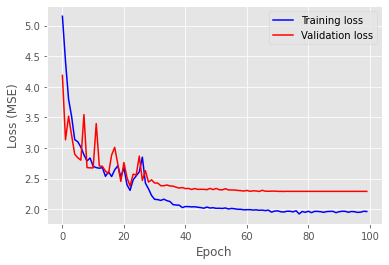

In [76]:
plt.plot(train_loss_arr,'b',label='Training loss')
plt.plot(validation_loss_arr,'r',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.plot()
plt.show()